In [1]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to exp/nb_06.py


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export 
from exp.nb_05b import *
torch.set_num_threads(2)

# Convnet

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
#export
def get_data():
    mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items = get_image_files,
                 splitter = GrandparentSplitter('training', 'testing'),
                 get_y = parent_label)
    dls = mnist.dataloaders(untar_data(URLs.MNIST))
    x_train, y_train = zip(*dls.train_ds)
    x_valid, y_valid = zip(*dls.valid_ds)

    x_train = tensor(list(map(array, x_train)), dtype=torch.float32).view(len(dls.train_ds), -1)
    x_valid = tensor(list(map(array, x_valid)), dtype=torch.float32).view(len(dls.valid_ds), -1)
    y_train = tensor(y_train)
    y_valid = tensor(y_valid)
    
    x_train, x_valid = x_train / 255.0, x_valid / 255.0
    x_train, x_valid = normalize_to(x_train, x_valid)

    return x_train, y_train, x_valid, y_valid

In [6]:
x_train, y_train, x_valid, y_valid = get_data()

In [7]:
x_train.mean(), x_train.std()

(tensor(-9.9649e-10), tensor(1.0000))

In [8]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [9]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [10]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [11]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)

In [12]:
#export
def flatten(x): return x.view(x.shape[0], -1)

def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [13]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, stride=2, padding=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(), #7
        nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(), #4
        nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ReLU(), #2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [14]:
model = get_cnn_model(data)

In [15]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [16]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [17]:
%time run.fit(1, learn)

train: [1.8957772135416666, tensor(0.3247)]
valid: [1.081099609375, tensor(0.5984)]
CPU times: user 8.41 s, sys: 96.1 ms, total: 8.5 s
Wall time: 4.25 s


# CUDA

In [18]:
device = torch.device('cuda', 0)

In [19]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model = self.model.to(self.device)
    def begin_batch(self): self.run.xb, self.run.yb = self.run.xb.to(self.device), self.run.yb.to(self.device)

In [20]:
torch.cuda.set_device(device)

In [21]:
class CudaCallback(Callback):
    def __init__(self): pass
    def begin_fit(self): self.model = self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.run.xb.cuda(), self.run.yb.cuda()

In [22]:
cbfs.append(CudaCallback)

In [23]:
model = get_cnn_model(data)

In [24]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [25]:
%time run.fit(3, learn)

train: [1.7441283854166667, tensor(0.3909, device='cuda:0')]
valid: [0.43174150390625, tensor(0.8685, device='cuda:0')]
train: [0.2641247395833333, tensor(0.9220, device='cuda:0')]
valid: [0.2915961181640625, tensor(0.9077, device='cuda:0')]
train: [0.151047998046875, tensor(0.9549, device='cuda:0')]
valid: [0.158105126953125, tensor(0.9498, device='cuda:0')]
CPU times: user 4.83 s, sys: 520 ms, total: 5.35 s
Wall time: 4.78 s


# Refactor model

In [26]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2), nn.ReLU()
    )

In [27]:
#export
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

In [28]:
#export
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    
    return _inner

In [29]:
mnist_view = view_tfm(1, 28, 28)

In [30]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [31]:
nfs = [8, 16, 32, 32]

In [32]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i == 0 else  3) for i in range(len(nfs) - 1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [33]:
def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [34]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    "returns learner and runner"
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [35]:
model = get_cnn_model(data, nfs)

In [36]:
learn, run  = get_runner(model, data, lr=0.4, cbs=cbfs)

In [37]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [38]:
run.fit(3, learn)

train: [2.0800696614583334, tensor(0.2397, device='cuda:0')]
valid: [1.5169390625, tensor(0.5695, device='cuda:0')]
train: [0.5020986653645834, tensor(0.8369, device='cuda:0')]
valid: [0.2659894287109375, tensor(0.9204, device='cuda:0')]
train: [0.19347081705729166, tensor(0.9416, device='cuda:0')]
valid: [0.19410384521484375, tensor(0.9396, device='cuda:0')]


# Hooks

In [39]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in self.layers]
        self.act_stds = [[] for _ in self.layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
            
        return x
    
    def __iter__(self): return iter(self.layers)

In [40]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [41]:
run.fit(2, learn)

train: [1.7196498697916667, tensor(0.4094, device='cuda:0')]
valid: [0.77157314453125, tensor(0.7379, device='cuda:0')]
train: [0.42511103515625, tensor(0.8752, device='cuda:0')]
valid: [0.50062578125, tensor(0.8615, device='cuda:0')]


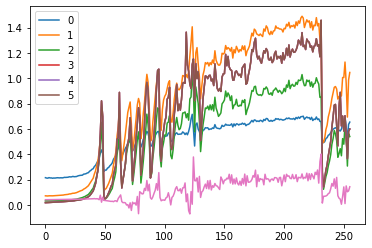

In [42]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

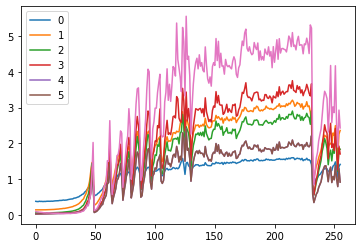

In [43]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

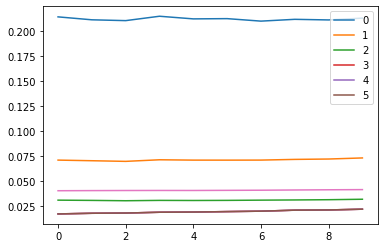

In [44]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

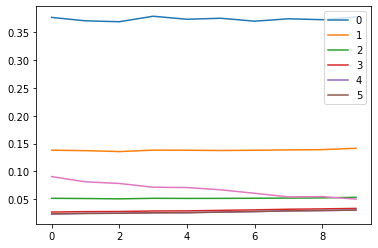

In [45]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

## Pytorch Hooks

In [89]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [90]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [91]:
len(act_means)

7

In [92]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [93]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [94]:
run.fit(1, learn)

train: [1.8117190104166667, tensor(0.3667, device='cuda:0')]
valid: [0.519172265625, tensor(0.8222, device='cuda:0')]


In [95]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [96]:
len(model)

7

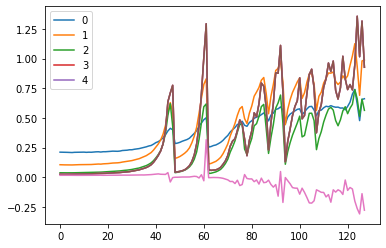

In [97]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

## Hook class

In [98]:
#export
def children(m): return list(m.children())


class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def __del__(self): self.remove()
    def remove(self): self.hook.remove()
        

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [99]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [100]:
[print(child) for child in model.children()]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
Sequential(
  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
AdaptiveAvgPool2d(output_size=1)
Lambda()
Linear(in_features=32, out_features=10, bias=True)


[None, None, None, None, None, None, None]

In [101]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [102]:
run.fit(1, learn)

train: [1.89811328125, tensor(0.3320, device='cuda:0')]
valid: [1.470724609375, tensor(0.5446, device='cuda:0')]


In [114]:
len(hooks)

4

In [113]:
len(hooks[0].stats[0])

128

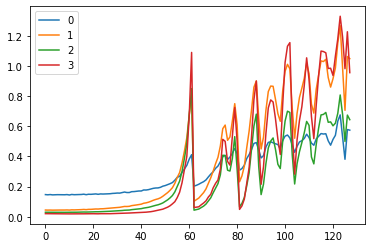

In [103]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

# A hooks class

In [61]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)
            return [o for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = 0
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f"{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}"
        if len(self) > 10: res = res[:-1] + "...]"
        return res

In [62]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [63]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [64]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [65]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, model, f): super().__init__([Hook(m, f) for m in model])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for  h in self: h.remove()

In [66]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [67]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f978cb114c0>, <__main__.Hook object at 0x7f978cb11b80>, <__main__.Hook object at 0x7f978cb11c70>, <__main__.Hook object at 0x7f978cb11d30>, <__main__.Hook object at 0x7f978cb116a0>, <__main__.Hook object at 0x7f978cb11340>, <__main__.Hook object at 0x7f978cb11f70>]

In [68]:
hooks.remove()

In [69]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [70]:
x.mean(), x.std()

(tensor(-0.0069, device='cuda:0'), tensor(0.9921, device='cuda:0'))

In [71]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4093, device='cuda:0', grad_fn=<StdBackward0>))

In [72]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [73]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.3261, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5404, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.707924609375, tensor(0.4383, device='cuda:0')]
valid: [0.460689306640625, tensor(0.8614, device='cuda:0')]
train: [0.27839287109375, tensor(0.9160, device='cuda:0')]
valid: [0.2150352294921875, tensor(0.9325, device='cuda:0')]


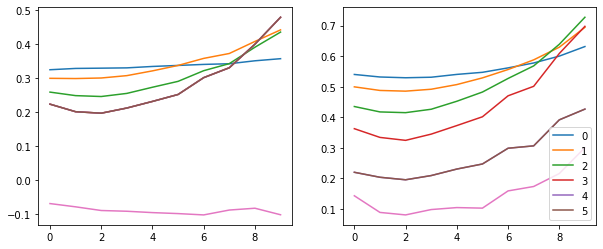

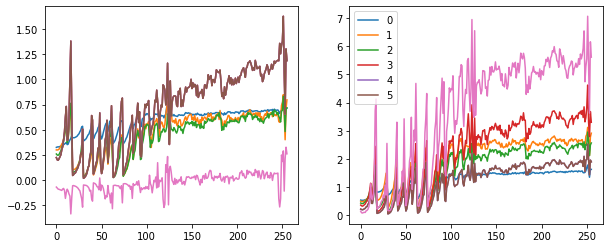

In [74]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

# Other statistics

In [118]:
# torch.histc(bins, min, max)

In [119]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))

In [120]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [121]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [122]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.37838515625, tensor(0.5577, device='cuda:0')]
valid: [0.336736328125, tensor(0.8982, device='cuda:0')]


In [123]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [125]:
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f978b609ee0>, <__main__.Hook object at 0x7f978b6097c0>, <__main__.Hook object at 0x7f978b609790>, <__main__.Hook object at 0x7f978b6098b0>, <__main__.Hook object at 0x7f978b609f40>, <__main__.Hook object at 0x7f978b609fd0>, <__main__.Hook object at 0x7f978b6096a0>]

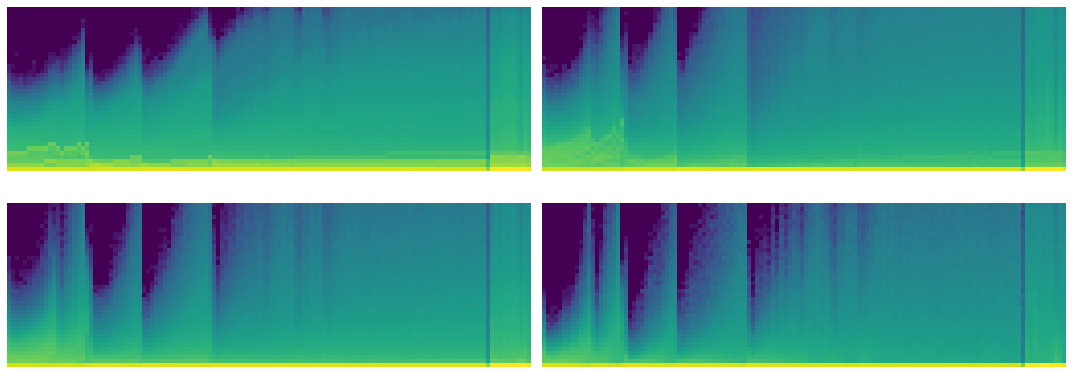

In [128]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]): # the first 4 are the conv layers
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [132]:
len(hooks[0].stats[2])

128

In [141]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    print(h1.shape)
    return h1[:2].sum(0) / h1.sum(0)

In [ ]:
# 40 for 40 bins

torch.Size([40, 128])
torch.Size([40, 128])
torch.Size([40, 128])
torch.Size([40, 128])


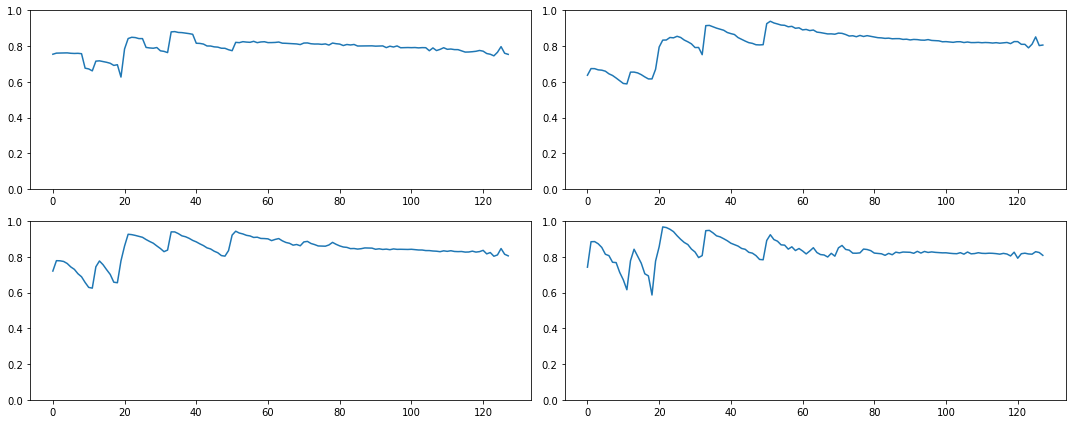

In [142]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]): 
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Generalized ReLU

In [152]:
#export
def get_cnn_layers(data, nfs, layers, **kwargs):
    nfs = [1] + nfs
    return [layers(nfs[i], nfs[i+1], 5 if i == 0 else 3) for i in range(len(nfs) - 1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]
    
def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2), GeneralRelu(**kwargs)
    )

def get_cnn_model(data, nfs, layers, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layers, **kwargs))

In [153]:
#export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [154]:
#export
def init_cnn(model, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in model:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

In [155]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [196]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.6, cbs=cbfs)

train: [0.8705106770833333, tensor(0.7237, device='cuda:0')]
valid: [0.1862535400390625, tensor(0.9407, device='cuda:0')]


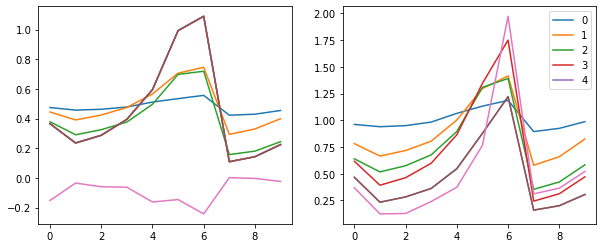

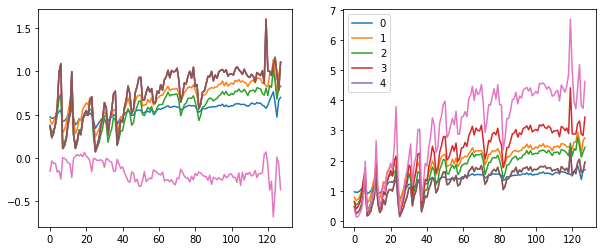

In [197]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

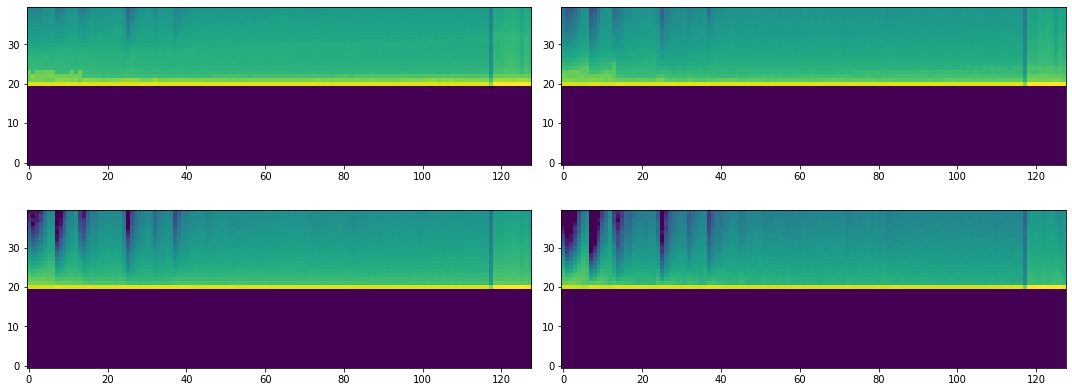

In [209]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
#     ax.axis('off')
plt.tight_layout()

In [207]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0) / h1.sum(0)

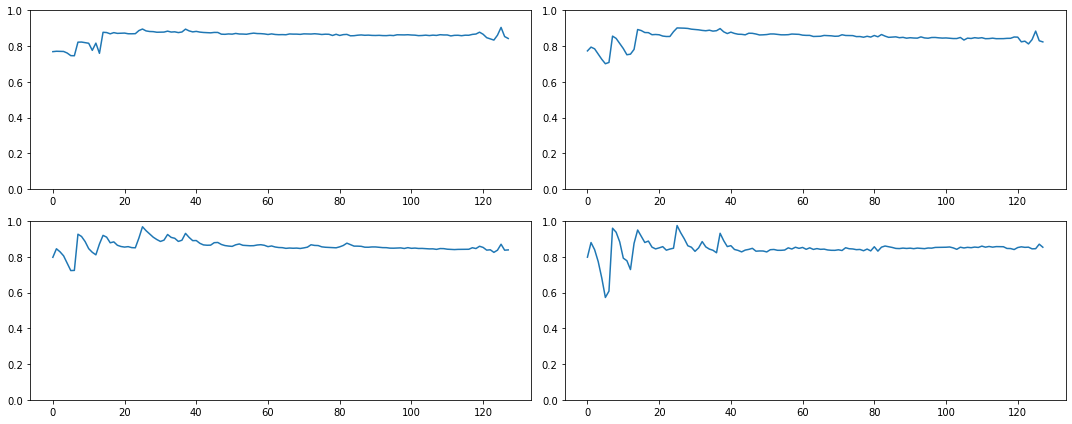

In [208]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [213]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [214]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1), sched_cos(1., 0.1)])

In [215]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [216]:
run.fit(8, learn)

train: [0.8650615885416667, tensor(0.7361, device='cuda:0')]
valid: [0.3266324951171875, tensor(0.8970, device='cuda:0')]
train: [0.3289134765625, tensor(0.9038, device='cuda:0')]
valid: [0.417487109375, tensor(0.8793, device='cuda:0')]
train: [0.181081982421875, tensor(0.9437, device='cuda:0')]
valid: [0.225121923828125, tensor(0.9384, device='cuda:0')]
train: [0.159976708984375, tensor(0.9514, device='cuda:0')]
valid: [0.18988370361328125, tensor(0.9421, device='cuda:0')]
train: [0.07594788411458334, tensor(0.9778, device='cuda:0')]
valid: [0.07732278442382813, tensor(0.9763, device='cuda:0')]
train: [0.0519110595703125, tensor(0.9844, device='cuda:0')]
valid: [0.049664044189453124, tensor(0.9836, device='cuda:0')]
train: [0.03898978271484375, tensor(0.9883, device='cuda:0')]
valid: [0.046755865478515624, tensor(0.9854, device='cuda:0')]
train: [0.03196495157877604, tensor(0.9906, device='cuda:0')]
valid: [0.04445775451660156, tensor(0.9870, device='cuda:0')]


In [217]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)], uniform=True)

In [218]:
run.fit(8, learn)

train: [1.1458680989583334, tensor(0.6362, device='cuda:0')]
valid: [0.32377177734375, tensor(0.8980, device='cuda:0')]
train: [0.29813655598958333, tensor(0.9096, device='cuda:0')]
valid: [0.1782704833984375, tensor(0.9468, device='cuda:0')]
train: [0.17890804036458333, tensor(0.9460, device='cuda:0')]
valid: [0.208846533203125, tensor(0.9358, device='cuda:0')]
train: [0.11444925130208333, tensor(0.9649, device='cuda:0')]
valid: [0.09697310180664062, tensor(0.9691, device='cuda:0')]
train: [0.06783389485677083, tensor(0.9789, device='cuda:0')]
valid: [0.06290677490234375, tensor(0.9796, device='cuda:0')]
train: [0.04728838297526042, tensor(0.9852, device='cuda:0')]
valid: [0.0620203857421875, tensor(0.9799, device='cuda:0')]
train: [0.035449589029947916, tensor(0.9894, device='cuda:0')]
valid: [0.04811019592285156, tensor(0.9846, device='cuda:0')]
train: [0.027458203125, tensor(0.9922, device='cuda:0')]
valid: [0.04666975402832031, tensor(0.9852, device='cuda:0')]


# Export

In [220]:
from IPython.display import display, Javascript

def nb_auto_export():
    display(Javascript("""{
    const ip = IPython.notebook
    if (ip) {
        ip.save_notebook()
        console.log('a')
        const s = `!python notebook2script.py ${ip.notebook_name}`
        if (ip.kernel) { ip.kernel.execute(s) }
    }
    }"""))

In [221]:
nb_auto_export()

<IPython.core.display.Javascript object>